# Contexts and their generation
## Scenario 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils.User_Classes import UserClass
from p4.Multi_TS_Learner import Multi_TS_Learner
from p4.class_joint_environment import Environment

In [2]:
uc1 = UserClass(name = "C1")
uc2 = UserClass(name = "C2")
uc3 = UserClass(name = "C3")

user_classes = [uc1, uc2, uc3]

## Experiments

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
from p4.Multi_TS_Learner import *

class ContextManager:
    def __init__(self):
        self.features_names = ['f1', 'f2']
        self.features = ['00', '01', '10', '11'] #11 probably not necessary
        self.samples = pd.DataFrame(columns=[*self.features_names, 'bid', 'price', 'n_conversions', 'n_clicks', 'cum_costs', 'reward'])        
        self.prices = [50, 100, 150, 200, 250]
        self.bids = np.linspace(0.01, 3.0, 100)

    def update(self, new_samples):
        new_samples_df = pd.DataFrame(new_samples,
                                      columns=[*self.features_names, 'bid', 'price', 'n_conversions', 'n_clicks',
                                               'cum_costs',
                                               'reward'])
        self.samples = pd.concat([self.samples, new_samples_df])
    
    def get_context(self):  # convert list of dictionaries into list of lists
        context_dict = self.get_context_recursive()
        context_list = []
        if len(context_dict) == 0:
            return [self.features]
        for dictionary in context_dict:
            class_list = []
            for i in range(2): #for each feature
                if self.features_names[i] not in dictionary.keys():
                    class_list_copy = class_list.copy()
                    if len(class_list_copy) == 0:
                        class_list = [['0'], ['1']]
                    else:
                        for class_name_list in class_list_copy:
                            class_name_list_0 = class_name_list + ['0']
                            class_name_list_1 = class_name_list + ['1']
                            class_list.append(class_name_list_0)
                            class_list.append(class_name_list_1)
                            class_list.remove(class_name_list)
                else:
                    if len(class_list) == 0:
                        class_list = [[str(dictionary[self.features_names[i]])]]
                    else:
                        for class_name_list in class_list:
                            class_name_list.append(str(dictionary[self.features_names[i]]))
            context_list.append([''.join(class_name_list) for class_name_list in class_list])
        return context_list

    def get_context_recursive(self, features=['f1', 'f2'], samples=None, lower_bound_mean=None):
        if len(features) == 0:
            return []
        features_names_to_be_split = features.copy()
        if samples is None:
            samples = self.samples
            conversion_per_price = samples.groupby(['price'])['n_conversions'].sum().astype(float)
            n_clicks_per_price = samples.groupby(['price'])['n_clicks'].sum().astype(float)
            conversion_rate_per_price = conversion_per_price.divide(n_clicks_per_price).astype(float)
            lb_per_price = conversion_rate_per_price - np.sqrt(np.array(-np.log(0.95) / (2 * n_clicks_per_price)).astype(float)) #Hoeffding bound with a confidence of 0.95 (slide 29)
            lb_pricing_probability = lb_per_price.max()
            price_max_idx = lb_per_price.idxmax()
            margin = self.prices[price_max_idx] - self.prices[price_max_idx] * 0.3
            n_clicks_per_bid = samples.groupby(['bid'])['n_clicks']
            cum_costs_per_bid = samples.groupby(['bid'])['cum_costs']
            n_clicks_per_bid_lb = n_clicks_per_bid.mean().to_numpy() - 1.96 * n_clicks_per_bid.std().fillna(
                1e6).to_numpy() / np.sqrt(n_clicks_per_bid.size().to_numpy())
            cum_costs_per_bid_lb = cum_costs_per_bid.mean().to_numpy() + 1.96 * cum_costs_per_bid.std().fillna(
                1e6).to_numpy() / np.sqrt(cum_costs_per_bid.size().to_numpy())
            lower_bound_mean = np.max(
                (lb_pricing_probability * n_clicks_per_bid_lb * margin - cum_costs_per_bid_lb) / n_clicks_per_bid_lb)
        max_split_value = -np.infty
        max_feature = None
        max_filtered_samples_0 = None
        max_lower_bound_0 = None
        max_filtered_samples_1 = None
        max_lower_bound_1 = None
        for feature in features:
            # filter df
            filtered_samples_per_feature_0 = samples.copy().loc[samples[feature] == '0']
            lower_bounds_0 = self.get_lower_bounds(filtered_samples_per_feature_0, samples)
            filtered_samples_per_feature_1 = samples.copy().loc[samples[feature] == '1']
            lower_bounds_1 = self.get_lower_bounds(filtered_samples_per_feature_1, samples)
            split_value = lower_bounds_0[0] * lower_bounds_0[1] + lower_bounds_1[0] * lower_bounds_1[1]
            if split_value >= lower_bound_mean and split_value > max_split_value:
                max_split_value = split_value
                max_filtered_samples_0 = filtered_samples_per_feature_0.copy()
                max_lower_bound_0 = lower_bounds_0[1]
                max_filtered_samples_1 = filtered_samples_per_feature_1.copy()
                max_lower_bound_1 = lower_bounds_1[1]
                max_feature = feature
        if max_feature is not None:
            features_names_to_be_split.remove(max_feature)
            context_0 = self.get_context_recursive(features_names_to_be_split, max_filtered_samples_0,
                                                   max_lower_bound_0)
            if len(context_0) == 0:
                context_0.append({max_feature: 0})
            else:
                for sub_context in context_0:
                    sub_context[max_feature] = 0
            context_1 = self.get_context_recursive(features_names_to_be_split, max_filtered_samples_1,
                                                   max_lower_bound_1)
            if len(context_1) == 0:
                context_1.append({max_feature: 1})
            else:
                for sub_context in context_1:
                    sub_context[max_feature] = 1
            return context_0 + context_1
        return []
    
    def get_lower_bounds(self, filtered_samples, total_samples):
        n_samples_filtered = np.sum(filtered_samples['n_clicks'].to_numpy())
        n_samples_total = np.sum(total_samples['n_clicks'].to_numpy())
        lb_probability = n_samples_filtered / n_samples_total - np.sqrt(
            -np.log(0.95) / (2 * n_samples_filtered))

        conversion_per_price = filtered_samples.groupby(['price'])['n_conversions'].sum().astype(float)
        n_clicks_per_price = filtered_samples.groupby(['price'])['n_clicks'].sum().astype(float)
        conversion_rate_per_price = conversion_per_price.divide(n_clicks_per_price).astype(float)
        lb_per_price = conversion_rate_per_price - np.sqrt(
            np.array(-np.log(0.95) / (2 * n_clicks_per_price)).astype(float))
        lb_pricing_probability = lb_per_price.max()
        price_max_idx = lb_per_price.idxmax()
        margin = self.prices[price_max_idx] - self.prices[price_max_idx] * 0.3

        n_clicks_per_bid = filtered_samples.groupby(['bid'])['n_clicks']
        cum_costs_per_bid = filtered_samples.groupby(['bid'])['cum_costs']
        n_clicks_per_bid_lb = n_clicks_per_bid.mean().to_numpy() - 1.96 * n_clicks_per_bid.std().fillna(
            1e6).to_numpy() / np.sqrt(n_clicks_per_bid.size().to_numpy())
        cum_costs_per_bid_lb = cum_costs_per_bid.mean().to_numpy() + 1.96 * cum_costs_per_bid.std().fillna(
            1e6).to_numpy() / np.sqrt(cum_costs_per_bid.size().to_numpy())
        reward_mean_per_bid = (
                                          lb_pricing_probability * n_clicks_per_bid_lb * margin - cum_costs_per_bid_lb) / n_clicks_per_bid_lb
        return lb_probability, np.max(reward_mean_per_bid)

    def get_samples(self, context):
        filtered_samples = pd.DataFrame(
            columns=[*self.features_names, 'bid', 'price', 'n_conversions', 'n_clicks', 'cum_costs', 'reward'])
        for feature_combo in context:
            filtered_samples_per_feature = self.samples
            features = list(feature_combo)
            for i in range(len(self.features_names)):
                filtered_samples_per_feature = filtered_samples_per_feature.loc[
                    filtered_samples_per_feature[self.features_names[i]] == features[i]]
            filtered_samples = pd.concat([filtered_samples, filtered_samples_per_feature])
        return [filtered_samples[column].to_numpy() for column in filtered_samples.columns[2:]]

In [4]:
class ContextOptimizer:
    def __init__(self, optimizer_type):
        """
        param.features_names = [F1, F2]
        param.features_combos = [00, 01, 10, 11]
        optimizer_type: classe (MultiLearner: TS / UCB)
        """
        self.context_generator = ContextManager() #crea il context generator con la lista di feature e le possibili combinazioni
        self.optimizer_type = optimizer_type #assegna il learner
        self.prices = [50, 100, 150, 200, 250]
        self.bids = np.linspace(0.01, 3.0, 100)
        self.context_wise_learner = {
            tuple(['00', '01', '10', '11']): self.optimizer_type(self.bids, self.prices) #initializes one learner per context (each feature combination creates a context)
        }
        self.T = 0
        self.collected_rewards = []

    def pull_arms(self):
        bids_and_prices = {}
        """
        ad ora esiste solo un contesto "00 01 10 11"
        l'arm viene pullata e assegnata a tutti quei contesti
        """
        for context in self.context_wise_learner.keys(): #for each possible context (feature combination)
            #print(f"iterating on contexts. Now the context is {context}")
            arms = self.context_wise_learner[context].pull_arms() #pull arm
            #print(f"\tpulled arms: {arms}")
            for feature in context:
                #print(f"\titerating on features. Now {feature}")
                bids_and_prices[feature] = arms
        return bids_and_prices

    def update(self, input_per_feature):
        self.T += 1 #time step increment
        #iterates on each context
        for context in self.context_wise_learner.keys():
            """
            at this point
            - context = [00, 01, 10, 11]
            - input_per_feature contains [bid_index, price_index, #conversions, @clicks, total costs, reward] for each context
            for simplicity, we save the single value into their own variables
            """
            pulled_bids_arm = input_per_feature[context[0]][0]
            pulled_prices_arm = input_per_feature[context[0]][1]
            n_conversion_per_context = sum(input_per_feature[feature][2] for feature in context)
            n_clicks_per_context = sum(input_per_feature[feature][3] for feature in context)
            cum_cost_per_context = sum(input_per_feature[feature][4] for feature in context)
            reward_per_context = sum(input_per_feature[feature][5] for feature in context)
            #now we update the learner for this context
            self.context_wise_learner[context].update(pulled_bids_arm, pulled_prices_arm, n_conversion_per_context, n_clicks_per_context, cum_cost_per_context, reward_per_context)
        #and we collect the reward for each context. The total reward is just the sum
        self.collected_rewards.append(sum(input_per_feature[feature][5] for feature in ['00', '01', '10', '11']))
        self.context_generator.update([tuple(feature) + input_per_feature[feature] for feature in input_per_feature.keys()])
        
        #each two weeks we have to run the context generation algorithm
        if self.T % 14 == 0:
            context_structure = [tuple(i) for i in self.context_generator.get_context()] #we generate the context structure, aka -------------------------------------------------------
            keys = list(self.context_wise_learner.keys()).copy()
            for context in keys:
                if context not in context_structure:
                    del self.context_wise_learner[context]
            for context in context_structure:
                if context not in keys:
                    self.context_wise_learner[tuple(context)] = self.optimizer_type(self.bids, self.prices)
                    # retrieve samples
                    samples = self.context_generator.get_samples(context)
                    # bulk update learner
                    self.context_wise_learner[tuple(context)].update_bulk(*samples)

In [5]:
import numpy as np


class Environment:
    def __init__(self, feature):
        self.feature = feature
        self.user_class = self.compute_class_from_features(self.feature)
        self.prices = np.array([50, 100, 150, 200, 250])
        self.bids = np.linspace(0.01, 3.0, 100)
        self.n_bids_arms = len(self.bids)
        self.n_prices_arms = len(self.prices)
        self.pricing_probabilities = self.user_class.get_conversion_probabilities()
        self.optimal_price_idx = np.argmax(self.pricing_probabilities * (self.prices - self.prices * 0.3)) #TODO check this optimal formula
        self.n_clicks = self.user_class.get_click_bids(self.bids)
        self.cum_costs = self.user_class.get_total_cost(self.bids)#param.cum_cost_per_bid_by_feature[self.feature](param.bids)
        self.optimal = np.max(self.pricing_probabilities[self.optimal_price_idx] * self.n_clicks * ( #TODO: checks this optimal formula
                self.prices[self.optimal_price_idx] - self.prices[self.optimal_price_idx] * 0.3) - self.cum_costs)
        self.optimal_bid_idx = np.argmax(self.pricing_probabilities[self.optimal_price_idx] * self.n_clicks * ( #TODO: checks this optimal formula
                self.prices[self.optimal_price_idx] - self.prices[self.optimal_price_idx] * 0.3) - self.cum_costs)

    def round(self, pulled_bids_arm, pulled_prices_arm):
        bid = self.bids[pulled_bids_arm]
        price = self.prices[pulled_prices_arm]
        n_clicks = np.round(max(0,self.user_class.get_click_bids(bid) + np.random.normal(0, 10))).astype(np.int32)
        cum_cost = max(0, self.user_class.get_total_cost(bid) + np.random.normal(0, 200))
        result = np.random.binomial(1, self.pricing_probabilities[pulled_prices_arm], n_clicks)
        reward = np.sum(result) * (price - price*0.3) - cum_cost
        return np.sum(result), n_clicks, cum_cost, reward
    
    def compute_class_from_features(self, f):
        return UserClass(f1=f[0], f2=f[1])

In [6]:
envs = {feature: Environment(feature) for feature in ['00', '01', '10', '11']}
opts = {feature: envs[feature].optimal for feature in ['00', '01', '10', '11']}
n_experiments = 2
T = 100
prices = [50, 100, 150, 200, 250]
bids = np.linspace(0.01, 3.0, 100)

no_context_ts_rewards_per_experiment = []
context_ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    context_TS = ContextOptimizer(Multi_TS_Learner)
    nocontext_TS = Multi_TS_Learner(bids, prices)

    for t in range(0, T):
        if t % 10 == 0:
            print(f"{t} of experiment {e}")

        #context-generation using TS
        pulled_arms_per_feature = context_TS.pull_arms()
        optimizer_update_input = {}
        for feature in pulled_arms_per_feature.keys(): #.keys ritorna 00 01 10 11
            optimizer_update_input[feature] = pulled_arms_per_feature[feature] + envs[feature].round(*pulled_arms_per_feature[feature]) #ad ogni contesto assegno l'arm pullata sommata al round (perché la somma al round?)
        context_TS.update(optimizer_update_input) #e alla fine faccio l'update

        #TS with no context generation
        pulled_arms = nocontext_TS.pull_arms()
        total_conversions = 0
        total_n_clicks = 0
        total_cum_cost = 0
        total_reward = 0
        for feature in ['00', '01', '10', '11']:
            n_conversions, n_clicks, cum_cost, reward = envs[feature].round(*pulled_arms)
            total_conversions += n_conversions
            total_n_clicks += n_clicks
            total_cum_cost += cum_cost
            total_reward += reward
        nocontext_TS.update(*pulled_arms, total_conversions, total_n_clicks, total_cum_cost, total_reward)

    context_ts_rewards_per_experiment.append(context_TS.collected_rewards)
    no_context_ts_rewards_per_experiment.append(nocontext_TS.collected_rewards)

mean_cum_reward_ts_context = np.mean(context_ts_rewards_per_experiment, axis=0)
mean_cum_reward_ts_no_context = np.mean(no_context_ts_rewards_per_experiment, axis=0)

std_cum_reward_ts_context = np.std(context_ts_rewards_per_experiment, axis=0)
std_cum_reward_ts_no_context = np.std(no_context_ts_rewards_per_experiment, axis=0)

0 of experiment 0


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


10 of experiment 0


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


20 of experiment 0


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30 of experiment 0


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 of experiment 0
50 of experiment 0
60 of experiment 0
70 of experiment 0
80 of experiment 0
90 of experiment 0
0 of experiment 1


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: Converge

10 of experiment 1


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


20 of experiment 1


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


30 of experiment 1


c:\Users\Andrea\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


40 of experiment 1
50 of experiment 1
60 of experiment 1
70 of experiment 1
80 of experiment 1
90 of experiment 1


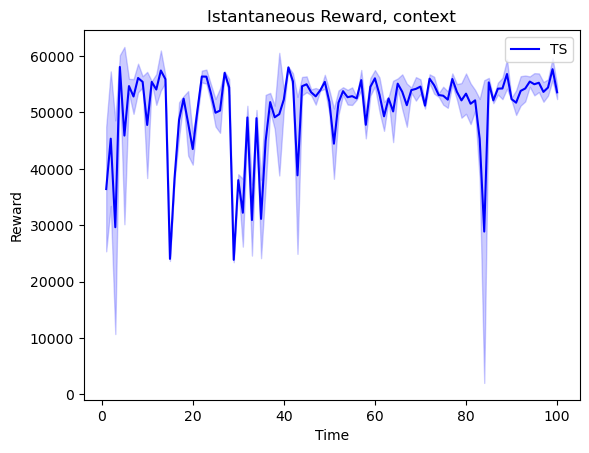

In [7]:
# CONTEXT TS REWARD IST
plt.plot(range(1, T+1), mean_cum_reward_ts_context, 'b', label='TS')
plt.fill_between(range(1, T+1), mean_cum_reward_ts_context - std_cum_reward_ts_context, mean_cum_reward_ts_context + std_cum_reward_ts_context, alpha=0.2, color='b')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward, context')
plt.legend()
plt.show()

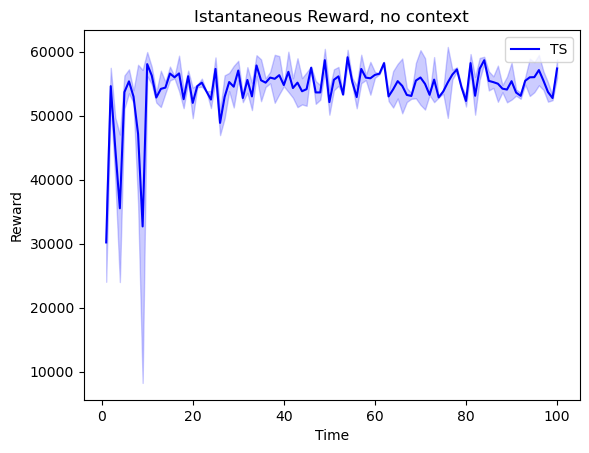

In [8]:
# NO CONTEXT TS REWARD IST
plt.plot(range(1, T+1), mean_cum_reward_ts_no_context, 'b', label='TS')
plt.fill_between(range(1, T+1), mean_cum_reward_ts_no_context - std_cum_reward_ts_no_context, mean_cum_reward_ts_no_context + std_cum_reward_ts_no_context, alpha=0.2, color='b')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward, no context')
plt.legend()
plt.show()

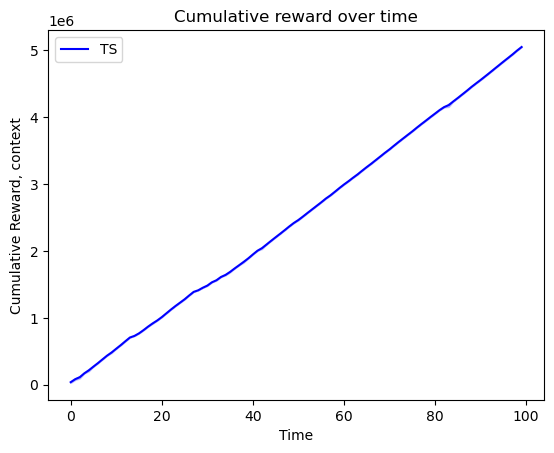

In [9]:
# CONTEXT TS REWARD CUM
plt.ylabel("Cumulative Reward, context")
plt.xlabel("Time")
plt.title("Cumulative reward over time")
plt.plot(np.cumsum(np.mean(context_ts_rewards_per_experiment, axis=0)), 'b', label='TS')
plt.fill_between(range(len(mean_cum_reward_ts_context)), np.cumsum(mean_cum_reward_ts_context) - std_cum_reward_ts_context, np.cumsum(mean_cum_reward_ts_context) + std_cum_reward_ts_context, alpha=0.2, color='b')

plt.legend()
plt.show()

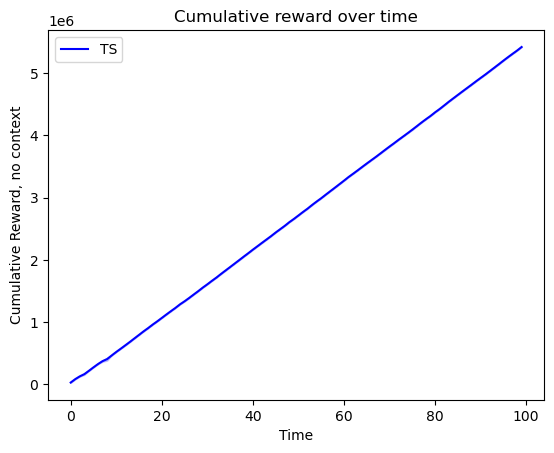

In [10]:
# NO CONTEXT TS REWARD CUM
plt.ylabel("Cumulative Reward, no context")
plt.xlabel("Time")
plt.title("Cumulative reward over time")
plt.plot(np.cumsum(np.mean(no_context_ts_rewards_per_experiment, axis=0)), 'b', label='TS')
plt.fill_between(range(len(mean_cum_reward_ts_no_context)), np.cumsum(mean_cum_reward_ts_no_context) - std_cum_reward_ts_no_context, np.cumsum(mean_cum_reward_ts_no_context) + std_cum_reward_ts_no_context, alpha=0.2, color='b')

plt.legend()
plt.show()

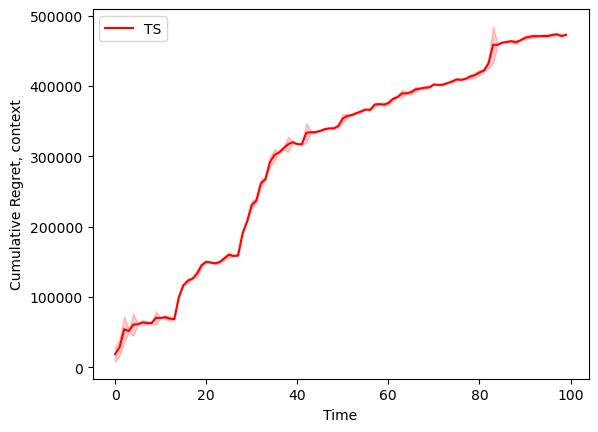

In [11]:
opts = {feature: envs[feature].optimal for feature in ['00', '01', '10', '11']}
opt = sum(opts.values())

#CONTEXT REGRET CUM
mean_cum_regret_ts = np.mean(opt - np.array(context_ts_rewards_per_experiment), axis=0)
std_cum_regret_ts = np.std(opt - np.array(context_ts_rewards_per_experiment), axis=0)

# Plot mean and standard deviation
plt.plot(np.cumsum(mean_cum_regret_ts), 'r', label='TS')
plt.fill_between(range(len(mean_cum_regret_ts)), np.cumsum(mean_cum_regret_ts) - std_cum_regret_ts, np.cumsum(mean_cum_regret_ts) + std_cum_regret_ts, alpha=0.2, color='r')
plt.ylabel("Cumulative Regret, context")
plt.xlabel("Time")
#plt.plot(np.cumsum(opt - np.array(mean_cum_reward_ts), axis=0), 'r')
plt.legend(["TS"])
plt.show()

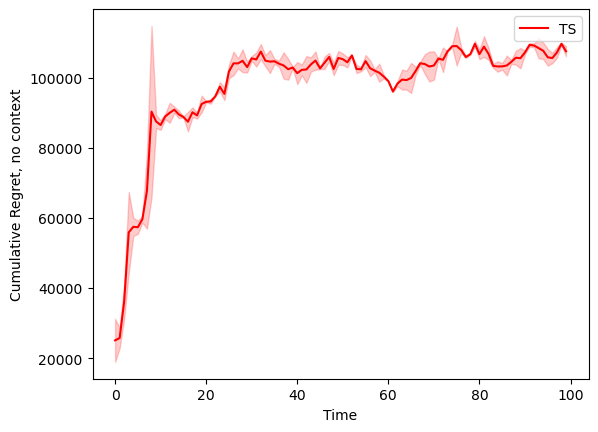

In [12]:
#NO CONTEXT REGRET CUM

mean_cum_regret_ts = np.mean(opt - np.array(no_context_ts_rewards_per_experiment), axis=0)
std_cum_regret_ts = np.std(opt - np.array(no_context_ts_rewards_per_experiment), axis=0)

# Plot mean and standard deviation
plt.plot(np.cumsum(mean_cum_regret_ts), 'r', label='TS')
plt.fill_between(range(len(mean_cum_regret_ts)), np.cumsum(mean_cum_regret_ts) - std_cum_regret_ts, np.cumsum(mean_cum_regret_ts) + std_cum_regret_ts, alpha=0.2, color='r')
plt.ylabel("Cumulative Regret, no context")
plt.xlabel("Time")
#plt.plot(np.cumsum(opt - np.array(mean_cum_reward_ts), axis=0), 'r')
plt.legend(["TS"])
plt.show()

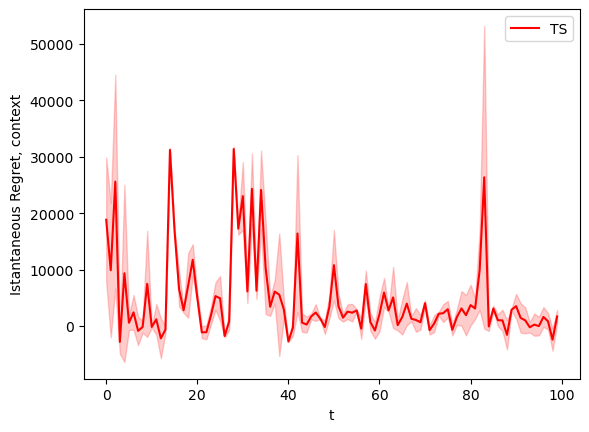

In [13]:
# CONTEXT REGRET IST
mean_inst_regret_ts = opt - np.mean(np.array(context_ts_rewards_per_experiment), axis=0)
std_inst_regret_ts = np.std(opt - np.array(context_ts_rewards_per_experiment), axis=0)

plt.ylabel("Istantaneous Regret, context")
plt.xlabel("t")
plt.plot(mean_inst_regret_ts, 'r', label='TS')
plt.fill_between(range(len(mean_inst_regret_ts)), mean_inst_regret_ts - std_inst_regret_ts, mean_inst_regret_ts + std_inst_regret_ts, alpha=0.2, color='r')
#plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.legend()
plt.show()

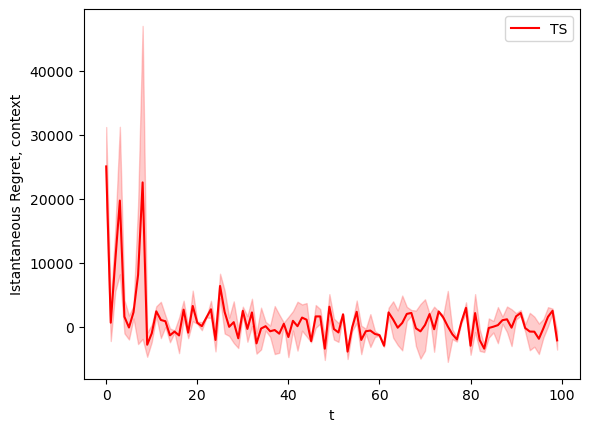

In [14]:
# NO CONTEXT REGRET IST
mean_inst_regret_ts = opt - np.mean(np.array(no_context_ts_rewards_per_experiment), axis=0)
std_inst_regret_ts = np.std(opt - np.array(no_context_ts_rewards_per_experiment), axis=0)

plt.ylabel("Istantaneous Regret, no context")
plt.xlabel("t")
plt.plot(mean_inst_regret_ts, 'r', label='TS')
plt.fill_between(range(len(mean_inst_regret_ts)), mean_inst_regret_ts - std_inst_regret_ts, mean_inst_regret_ts + std_inst_regret_ts, alpha=0.2, color='r')
#plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.legend()
plt.show()